<h4>A dataset for country level analysis</h4>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

In [52]:
# fdi inflows in current US$
fdi_inflows = pd.read_csv("Data_Extract_From_World_Development_Indicators/fdi_inflows.csv", skipinitialspace=True)
fdi_inflows.drop(fdi_inflows.tail(5).index,inplace=True)
fdi = pd.melt(fdi_inflows, id_vars=['Series Name', 'Series Code', 'Country Name', 'Country Code'], var_name='YR', value_name='fdi_inflows')
fdi['year'] = fdi['YR'].str[:4].astype(int)
fdi.drop(columns=['Series Name', 'Series Code', 'Country Name', 'YR'], inplace=True)
fdi.rename(columns={'Country Code': 'iso_code'}, inplace=True)

# to get constant 2010 US$ we need cpi
cpi_us = pd.read_csv("Data_Extract_From_World_Development_Indicators/cpi_us.csv", skipinitialspace=True)
cpi_us.drop(cpi_us.tail(5).index,inplace=True)
cpi = pd.melt(cpi_us, id_vars=['Series Name', 'Series Code', 'Country Name', 'Country Code'], var_name='YR', value_name='cpi')
cpi['year'] = cpi['YR'].str[:4].astype(int)
cpi.drop(columns=['Series Name', 'Series Code', 'Country Name', 'YR', 'Country Code'], inplace=True)
cpi['cpi'] = (cpi.cpi / 100)
fdi = pd.merge(fdi, cpi, on='year', how='left')
fdi.fdi_inflows = pd.to_numeric(fdi.fdi_inflows, errors='coerce')
fdi.cpi = pd.to_numeric(fdi.cpi, errors='coerce')
fdi['fdi'] = fdi.fdi_inflows / fdi.cpi
fdi.drop(columns=['fdi_inflows', 'cpi'], inplace=True)

fdi

,iso_code,year,fdi
0,AFG,1995,-1.335474e+05
1,ALB,1995,1.001677e+08
2,DZA,1995,1.430967e+03
3,ASM,1995,NaN
4,AND,1995,NaN
...,...,...,...
5420,VIR,2019,NaN
5421,PSE,2019,NaN
5422,YEM,2019,NaN
5423,ZMB,2019,4.106001e+08


<h5>Country level GDL data:</h5>
<p>The data for country level variables is downloaded instead of aggregated from regional level.</p>

,iso_code,year,iwipov70,iwipov50,iwipov35,shdi_educ,shdi_health,shdi_income,iwi,regpopm,shdi,ln_pop,steel,exports,ln_steel
868,AFG,1998,NaN,NaN,NaN,0.213,0.537,0.343,NaN,19700000.0,0.340,16.796129,114588.0,NaN,11.649098
869,ALB,1998,NaN,NaN,NaN,0.580,0.819,0.576,NaN,3130000.0,0.649,14.956544,114588.0,NaN,11.649098
870,DZA,1998,NaN,NaN,NaN,0.473,0.765,0.688,NaN,30200000.0,0.629,17.223352,114588.0,NaN,11.649098
871,AGO,1998,0.977,0.912,0.804,NaN,NaN,NaN,20.5,NaN,NaN,NaN,114588.0,NaN,11.649098
872,ARG,1998,NaN,NaN,NaN,0.681,0.819,0.763,NaN,36100000.0,0.752,17.401803,114588.0,NaN,11.649098


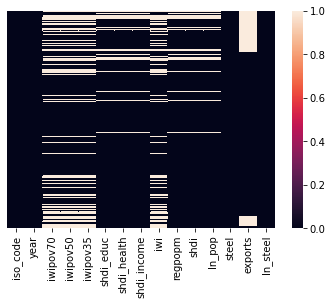

In [53]:
import glob
filenames = glob.glob('gdl_iso' + "\*.csv")
filetitle = ["iwipov70", "iwipov50", "iwipov35", "shdi_educ", "shdi_health","shdi_income", "iwi", "regpopm", "shdi"]
files_dict = dict(zip(filenames, filetitle))

li = []
for filename in files_dict:
    df = pd.melt(pd.read_csv(filename, skipinitialspace=True),id_vars=['Country', 'ISO_Code', 'Level', 'GDLCODE', 'Region'],var_name='year', value_name=files_dict.get(filename))
    df.drop(columns=['Country', 'Region', 'Level', 'GDLCODE'], inplace=True)
    li.append(df)
    pass
gdl_iso = reduce(lambda df1, df2: df1.merge(df2, "outer"), li)

gdl_iso['year'] = gdl_iso['year'].apply(int)

# merge mean household size by region
    # hhsize = pd.melt(pd.read_csv("hh/GDL-Average-household-size-data-national.csv", skipinitialspace=True), id_vars=['Country', 'ISO_Code', 'Level', 'GDLCODE', 'Region'],var_name='year', value_name='hhsize')
    # hhsize = hhsize.pivot_table(index='ISO_Code', values='hhsize', aggfunc='mean').reset_index()
    # gdl_iso = pd.merge(gdl_iso, hhsize, on='ISO_Code', how='left')

# add log of population
gdl_iso['regpopm'].values[gdl_iso['regpopm'] == 0] = np.nan
gdl_iso['regpopm'] = gdl_iso['regpopm'] * 1000000
gdl_iso['ln_pop'] = np.log(gdl_iso['regpopm'])

# change % variable decimal format
gdl_iso['iwipov35'] = gdl_iso['iwipov35'] / 100
gdl_iso['iwipov50'] = gdl_iso['iwipov50'] / 100
gdl_iso['iwipov70'] = gdl_iso['iwipov70'] / 100

# generate useable continuous dependent variables
    # gdl1 = gdl_iso.dropna(subset=['iwipov35', 'iwipov50', 'iwipov70', 'regpopm', 'hhsize']).copy()
    # gdl1 = gdl1[gdl1.iwipov35 != 0]
    # gdl1 = gdl1[gdl1.iwipov50 != 0]
    # gdl1 = gdl1[gdl1.iwipov70 != 0]
# generate continuous dependant variable: number of households below poverty levels of IWI 35, 50 & 70
    # gdl1['hhpov35'] = (gdl1.regpopm / gdl1.hhsize) * gdl1.iwipov35
    # gdl1['hhpov50'] = (gdl1.regpopm / gdl1.hhsize) * gdl1.iwipov50
    # gdl1['hhpov70'] = (gdl1.regpopm / gdl1.hhsize) * gdl1.iwipov70
    # gdl1['ln_hhpov35'] = np.log(gdl1.hhpov35)
    # gdl1['ln_hhpov50'] = np.log(gdl1.hhpov50)
    # gdl1['ln_hhpov70'] = np.log(gdl1.hhpov70)
# generate continuous dependant variable: population below poverty levels of IWI 35, 50 & 70
    # gdl1['poppov35'] = gdl1.hhpov35 * gdl1.hhsize
    # gdl1['poppov50'] = gdl1.hhpov50 * gdl1.hhsize
    # gdl1['poppov70'] = gdl1.hhpov70 * gdl1.hhsize
    # gdl1['ln_poppov35'] = np.log(gdl1.poppov35)
    # gdl1['ln_poppov50'] = np.log(gdl1.poppov50)
    # gdl1['ln_poppov70'] = np.log(gdl1.poppov70)
# merge to gdl data 
    # gdl1.drop(columns=['iwipov35', 'iwipov50', 'iwipov70', 'iwi', 'regpopm', 'ln_pop', 'hhsize'], inplace=True)
    # gdl_iso = pd.merge(gdl_iso, gdl1, on=['ISO_Code', 'year'], how='left')

# add steel figures
cnsteel = pd.read_csv("cn_steel_1998-2018.csv", thousands=',')
# merge to gdl
gdl_iso_steel = pd.merge(gdl_iso, cnsteel, how="left", on='year')
# generate log steel variable
gdl_iso_steel['ln_steel'] = np.log(gdl_iso_steel.steel)

gdl_iso_steel.rename(columns={'ISO_Code':'iso_code'}, inplace=True)

# time frame reduced to 1998 to 2018
gdl_iso_steel = gdl_iso_steel[(gdl_iso_steel.year > 1997) & (gdl_iso_steel.year < 2019)]


# remove countries with no projects or gdldata:
del_iso = ['AND', 'ARE', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BEL', 'BFA',
           'BGR', 'BHR', 'BHS', 'BLZ', 'BRN', 'BTN', 'CAN', 'CHE', 'CHN',
           'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'ESP', 'EST', 'FIN',
           'FJI', 'FRA', 'FSM', 'GBR', 'GMB', 'GRC', 'GRD', 'GTM', 'HND',
           'HRV', 'HUN', 'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KIR', 'KNA',
           'KOR', 'KWT', 'LBN', 'LBY', 'LCA', 'LIE', 'LKA', 'LTU', 'LUX',
           'LVA', 'MDV', 'MLT', 'NIC', 'NLD', 'NOR', 'NZL', 'OMN', 'PAN',
           'POL', 'PRT', 'PRY', 'QAT', 'ROU', 'RUS', 'SAU', 'SGP', 'SLB',
           'SLV', 'STP', 'SVK', 'SVN', 'SWE', 'SWZ', 'TON', 'USA', 'VCT',
           'WSM', 'XKO']
gdl_iso_steel = gdl_iso_steel[~gdl_iso_steel['iso_code'].isin(del_iso)]

display(gdl_iso_steel.head())
# heatmap shows us where we have missing values
sns.heatmap(gdl_iso_steel.isna(), yticklabels=False)
plt.show()

<h5>Country level counts, dummies, probabilities & amounts:</h5>

<p>The following dataframes are created for the country level dataset:</p>
    <li>Country level project counts & dummies</li>
    <li>Country level probabilities of receiving a development project</li> 
    <li>Country level project values</li>

In [54]:
cnfin = pd.read_csv("cnfin.csv", index_col=0)
projects_iso = cnfin[['iso_code', 'year']].copy()
# the dummay variable for all projects equal to 1 for each row in cnfin (0s assigned later)
projects_iso['total'] = 1
# generate dataframe with dummies per sector and flow class
crs_sector = pd.get_dummies(cnfin['crs_sector_name'])
flow_class = pd.get_dummies(cnfin['flow_class'])
# merge all dummmy dataframes
projects_iso = pd.concat([projects_iso, crs_sector, flow_class], axis=1)
# give short variable names
shortname = ['iso_code', 'year', 'total', 'debt', 'agri', 'bank', 'business', 'comms', 'food_aid', 'educ', 'emergency', 
             'energy', 'budget', 'environment', 'civil', 'health', 'industry', 'commod', 
             'multisector', 'social_infra', 'pop_policy', 'ngo_support', 'trade_tourism', 
             'transport', 'unspecified', 'water', 'women', 'oda', 'oof', 'vague']
rename_cols = dict(zip(projects_iso.columns,shortname))
projects_iso.columns = projects_iso.columns.map(rename_cols)
# aggregate dummies to get project counts by each region (GDLCODE) year combination
projects_iso = projects_iso.pivot_table(index = shortname[:2], values = shortname[2:], aggfunc = 'sum').reset_index()

projects_iso["social_sector"] = projects_iso.educ + projects_iso.health + projects_iso.water + projects_iso.civil + projects_iso.social_infra
projects_iso["economic_sector"] = projects_iso.transport + projects_iso.energy + projects_iso.comms + projects_iso.bank + projects_iso.business
projects_iso["productive_sector"] = projects_iso.agri + projects_iso.industry + projects_iso.trade_tourism

# generate binary variables if count is > 0 = 1 else 0
for column in projects_iso.columns[2:]:
    projects_iso[column+'_d'] = np.where(projects_iso[column]>=1, 1, 0)
    pass
dummies = list(projects_iso.columns[2:33])
# change the order so that total is first column (as it has the greatest number of observations so;
# sectors and flow class probabilities with lower observations can be merged using 'append' 
dummies[21], dummies[0] = dummies[0], dummies[21]
pivot = []
for i in dummies:
    p1 = projects_iso.pivot_table(index = ['iso_code', 'year'], values = i, aggfunc = 'sum').reset_index()
    p1 = p1[(p1[i] > 0)]
    p = p1.pivot_table(index = 'iso_code', values = 'year', aggfunc = pd.Series.nunique).reset_index()
    p['year'] = p['year'] / 15
    p.rename(columns = {'year':i+'_p'}, inplace = True) 
    pivot.append(p)
    pass
p_data_iso = reduce(lambda p1, p2: p1.merge(p2, "left"), pivot)
display(projects_iso.head())
display(p_data_iso.head())

,iso_code,year,agri,bank,budget,business,civil,commod,comms,debt,...,total_d,trade_tourism_d,transport_d,unspecified_d,vague_d,water_d,women_d,social_sector_d,economic_sector_d,productive_sector_d
0,AFG,2001,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,AFG,2002,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,AFG,2003,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
3,AFG,2006,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,AFG,2008,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0


,iso_code,total_p,bank_p,budget_p,business_p,civil_p,commod_p,comms_p,debt_p,educ_p,...,agri_p,trade_tourism_p,transport_p,unspecified_p,vague_p,water_p,women_p,social_sector_p,economic_sector_p,productive_sector_p
0,AFG,0.600000,NaN,0.066667,NaN,0.200000,NaN,0.066667,NaN,0.266667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533333,0.066667,NaN
1,AGO,0.800000,NaN,NaN,NaN,0.200000,NaN,0.133333,NaN,0.200000,...,0.133333,NaN,0.333333,NaN,0.2,0.266667,NaN,0.666667,0.533333,0.200000
2,ALB,0.600000,NaN,NaN,NaN,0.133333,NaN,0.066667,NaN,0.266667,...,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.133333,0.133333
3,ARG,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,0.200000,NaN
4,BDI,0.666667,NaN,NaN,NaN,NaN,NaN,0.133333,NaN,0.333333,...,NaN,NaN,0.066667,NaN,NaN,NaN,0.066667,0.533333,0.266667,NaN


In [55]:
# use dataset regions and aggregate amounts
amounts = pd.read_csv("data.csv", index_col=0)

amounts = amounts[['ISO_Code', 'year',  'debt_amount', 'agri_amount', 'bank_amount', 'business_amount', 'comms_amount',
                    'food_aid_amount', 'educ_amount', 'emergency_amount', 'energy_amount', 'budget_amount', 'environment_amount',
                    'civil_amount', 'health_amount', 'industry_amount', 'commod_amount', 'multisector_amount', 'social_infra_amount',
                    'pop_policy_amount', 'ngo_support_amount', 'trade_tourism_amount', 'transport_amount', 'unspecified_amount',
                    'water_amount', 'women_amount', 'total_amount', 'oda_amount', 'oof_amount']]

amounts = amounts.pivot_table(index = ['ISO_Code', 'year'], 
                              values = ['debt_amount', 'agri_amount', 'bank_amount', 'business_amount', 'comms_amount',
                                        'food_aid_amount', 'educ_amount', 'emergency_amount', 'energy_amount', 'budget_amount', 'environment_amount',
                                        'civil_amount', 'health_amount', 'industry_amount', 'commod_amount', 'multisector_amount', 'social_infra_amount',
                                        'pop_policy_amount', 'ngo_support_amount', 'trade_tourism_amount', 'transport_amount', 'unspecified_amount',
                                        'water_amount', 'women_amount', 'total_amount', 'oda_amount', 'oof_amount'], 
                              aggfunc = 'sum').reset_index()

for column in amounts.columns[2:]:
    amounts[column].values[amounts[column] == 0] = np.nan
    amounts['ln_'+column] = np.log(amounts[column])
    
amounts.rename(columns={'ISO_Code':'iso_code'}, inplace=True)

amounts.head()

,iso_code,year,agri_amount,bank_amount,budget_amount,business_amount,civil_amount,commod_amount,comms_amount,debt_amount,...,ln_oda_amount,ln_oof_amount,ln_pop_policy_amount,ln_social_infra_amount,ln_total_amount,ln_trade_tourism_amount,ln_transport_amount,ln_unspecified_amount,ln_water_amount,ln_women_amount
0,AFG,1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,2001,NaN,NaN,2.27,NaN,NaN,NaN,NaN,NaN,...,0.821317,NaN,NaN,NaN,0.821317,NaN,NaN,NaN,NaN,NaN
4,AFG,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.129166,NaN,NaN,-1.309333,2.129166,NaN,NaN,NaN,NaN,NaN


<h5>Merging to final country level dataset:</h5>

,iso_code,year,iwipov70,iwipov50,iwipov35,shdi_educ,shdi_health,shdi_income,iwi,regpopm,...,trade_tourism_p,transport_p,unspecified_p,vague_p,water_p,women_p,social_sector_p,economic_sector_p,productive_sector_p,fdi
0,AFG,1998,NaN,NaN,NaN,0.213,0.537,0.343,NaN,19700000.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.533333,0.066667,0.000000,-1.337695e+04
1,SEN,1998,0.8960,0.7660,0.6450,0.206,0.575,0.473,31.90,9350000.0,...,0.0,0.066667,0.0,0.133333,0.000000,0.0,0.333333,0.133333,0.200000,9.511792e+07
2,RWA,1998,0.9930,0.9800,0.9580,0.243,0.364,0.315,7.67,6960000.0,...,0.0,0.200000,0.0,0.133333,0.000000,0.0,0.466667,0.266667,0.266667,9.497637e+06
3,PHL,1998,0.7310,0.4260,0.2490,0.555,0.749,0.581,53.20,74700000.0,...,0.0,0.000000,0.0,0.000000,0.066667,0.0,0.200000,0.000000,0.333333,3.059309e+09
4,PER,1998,0.7210,0.5130,0.3920,0.613,0.773,0.626,46.60,25700000.0,...,0.0,0.066667,0.0,0.066667,0.000000,0.0,0.466667,0.066667,0.000000,2.199103e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,GEO,2018,NaN,NaN,NaN,0.856,0.825,0.689,NaN,3730000.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.400000,0.000000,0.000000,1.058251e+09
2180,GAB,2018,NaN,NaN,NaN,0.636,0.711,0.765,NaN,2120000.0,...,0.0,0.066667,0.0,0.000000,0.000000,0.0,0.466667,0.200000,0.066667,7.344328e+08
2181,ETH,2018,0.9480,0.8690,0.8030,0.335,0.711,0.435,22.30,109000000.0,...,0.0,0.600000,0.0,0.400000,0.000000,0.0,0.533333,0.733333,0.133333,2.918112e+09
2182,KAZ,2018,0.0823,0.0001,0.0001,0.817,0.819,0.816,83.40,18300000.0,...,0.0,0.000000,0.0,0.066667,0.000000,0.0,0.133333,0.200000,0.266667,1.857728e+08


,year,iwipov70,iwipov50,iwipov35,shdi_educ,shdi_health,shdi_income,iwi,regpopm,shdi,...,trade_tourism_p,transport_p,unspecified_p,vague_p,water_p,women_p,social_sector_p,economic_sector_p,productive_sector_p,fdi
count,2184.000000,1634.000000,1634.000000,1634.000000,2076.000000,2076.000000,2076.000000,1634.000000,2.076000e+03,2076.000000,...,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2184.000000,2.117000e+03
mean,2008.000000,0.634883,0.485134,0.379864,0.514344,0.689911,0.573747,51.125410,3.998093e+07,0.583765,...,0.002564,0.117949,0.001923,0.089744,0.028846,0.003205,0.393590,0.201282,0.092308,2.505536e+09
std,6.056687,0.337368,0.353001,0.332553,0.162444,0.138461,0.146545,25.165919,1.246868e+08,0.139486,...,0.012823,0.138778,0.014494,0.111645,0.056826,0.014265,0.250274,0.196592,0.107564,7.243827e+09
min,1998.000000,0.000100,0.000100,0.000000,0.108000,0.277000,0.250000,0.010000,2.100000e+05,0.247000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.373388e+09
25%,2003.000000,0.319250,0.100175,0.032200,0.389750,0.588000,0.458750,28.925000,3.750000e+06,0.464000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.066667,0.000000,9.376226e+07
50%,2008.000000,0.780000,0.536500,0.331500,0.515500,0.711000,0.576500,48.350000,1.190000e+07,0.595000,...,0.000000,0.066667,0.000000,0.066667,0.000000,0.000000,0.400000,0.133333,0.066667,4.224884e+08
75%,2013.000000,0.936000,0.832000,0.689750,0.652000,0.810000,0.702000,74.900000,3.155000e+07,0.704000,...,0.000000,0.200000,0.000000,0.133333,0.066667,0.000000,0.533333,0.333333,0.133333,1.706988e+09
max,2018.000000,0.999000,0.999000,0.999000,0.856000,0.925000,0.867000,98.200000,1.353000e+09,0.847000,...,0.066667,0.666667,0.133333,0.400000,0.266667,0.066667,1.000000,0.800000,0.466667,9.929272e+10


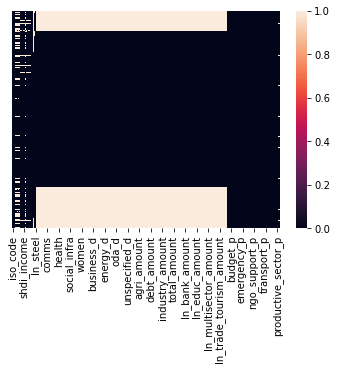

In [58]:
# merge by country - year
dfs = [gdl_iso_steel, projects_iso, amounts]
data_iso = reduce(lambda  left,right: pd.merge(left,right,on=['iso_code', 'year'], how='left'), dfs)

# fill NA values for counts, dummies & amounts (observed years)
fill_nan = data_iso.columns[15:]
for column in fill_nan:
    data_iso.fillna({column:0}, inplace=True)
    data_iso[column] = np.where((data_iso.year < 2000),np.nan,data_iso[column])
    data_iso[column] = np.where((data_iso.year > 2014),np.nan,data_iso[column])

# merge probabilities by country & fill nas (all years)
data_iso = pd.merge(data_iso, p_data_iso, how="left", on='iso_code')
fill_nan = data_iso.columns[131:]
for column in fill_nan:
    data_iso.fillna({column:0}, inplace=True)

data_iso.sort_values(by=['year'], inplace=True)

# remove outliers (high IWI regions with irregular projects)
outliers = []
data_iso = data_iso[~data_iso['iso_code'].isin(outliers)].reset_index()
data_iso.drop(columns=['index'], inplace=True)

# merge fdi
data_iso = pd.merge(data_iso, fdi, how="left", on=['iso_code', 'year'])

display(data_iso)
display(data_iso.describe())
display(sns.heatmap(data_iso.isna(), yticklabels=False))

<h4>Exports:</h4>
<p>Final dataset is exported in .dta for analysis in Stata. Analysis can be run using analysis.do found in the repository.</p>

In [59]:
data_iso.to_stata('data_iso.dta')
data_iso.to_csv('data_iso.csv')

<h5>Dataframe: visuals to support reduced form relationship</h5>

In [7]:
freq = p_data_iso[['iso_code', 'total_p']]
regular = freq[freq['total_p'] > p_data_iso['total_p'].median()]
irregular = freq[freq['total_p'] < p_data_iso['total_p'].median()]

reg = list(regular['iso_code'])
irreg = list(irregular['iso_code'])

reg_iwi = gdl_iso[gdl_iso['ISO_Code'].isin(reg)]
reg_iwi = reg_iwi.dropna(subset=['ISO_Code', 'year', 'iwipov50'])
reg_iwi = reg_iwi.pivot_table(index='year', values='iwipov50', aggfunc='mean').reset_index()
reg_iwi.rename(columns={'iwipov50':'reg_iwipov50'}, inplace=True)

irreg_iwi = gdl_iso[gdl_iso['ISO_Code'].isin(irreg)]
irreg_iwi = irreg_iwi.dropna(subset=['ISO_Code', 'year', 'iwipov50'])
irreg_iwi = irreg_iwi.pivot_table(index='year', values='iwipov50', aggfunc='mean').reset_index()
irreg_iwi.rename(columns={'iwipov50':'irreg_iwipov50'}, inplace=True)

steel = pd.read_csv('cn_steel_1998-2018.csv', thousands=',')
steel['L3_steel'] = steel.steel.shift(3)
steel['L3_steel'] = steel['L3_steel']/1000
steel = steel[['year', 'L3_steel']]
steel = steel.dropna()

plots3_dfs = [reg_iwi, irreg_iwi, steel]
plots3 = reduce(lambda  left,right: pd.merge(left,right,on=['year'], how='left'), plots3_dfs)

plots3.head()
# export
plots3.to_csv('plots3.csv')